# Exploring BERT

In [1]:
# Install huggingface BERT implementation

!pip install pytorch-pretrained-bert

In [2]:
import torch
from pytorch_pretrained_bert import BertTokenizer

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Inspecting BERT Vocabulary
--------------------------

**BERT is pre-trained, that is, its vocabulary is fixed.**  
How does it handle words that it does not have in its vocabulary, but that do exist in your application?  
_Old method_: define an UNK token and have an embedding for that token.

However, BERT does something better: if a word does not exist in its vocabulary, it uses the WordPiece model and breaks the word into multiple sub-words.

![title](./sem.jpg)

**What about really bizarre words?**  

BERT has embedding for every character in the alphabet, for many 2-letter phrases, 3-letter phrases, etc.  
If no embedding is found for any of the subwords, it would take embeddings of the characters.

![title](./stygix.jpg)

**When does it make sense to split word into subwords?**  

Probably, when you can get the meaning of the word based on its constituents. For example, down below is the frequency of different forms of 'flabbergast' in Wikipedia (2018 version). Even if the word did not occur in the training data, by splitting it into 'flabbergast' + 's', BERT should be able to learn that this is a completely valid form to use, although it has never seen it before.

![title](./flabber.png)

In [3]:
# let's retrieve the entire list of tokens in BERT's vocabulary

with open('vocabulary.txt', 'w') as f:
    
    # For each token...
    for token in tokenizer.vocab.keys():
        
        # Write it out and escape any unicode characters.            
        f.write(token + '\n')


In [4]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

As we can see in BERT's vocabulary, many words are starting with hash symbols. **Why?**

Based on WordPiece model, BERT greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. The vocabulary contains 4 things:

1. Whole words
2. Subwords occuring at the front of a word or in isolation (“em” as in “embeddings” is assigned the same vector as the standalone sequence of characters “em” as in “go get em” )
3. Subwords not at the front of a word, which are preceded by ‘##’ to denote this case
4. Individual characters

This seems to be useful when, for example, we have an uknown word, 'bedding', which is divided into 'bed' and '##ding'. It makes sense to divide the word this way, since the standalone embedding for 'bed' is useful for our known word, while '##ding' might be learned by the model.

Adding new tokens and fine-tuning embeddings for new tokens in BERT: https://github.com/huggingface/transformers/issues/1413

In [5]:
one_chars = []
one_chars_hashes = []

# For each token in the vocabulary...
for token in tokenizer.vocab.keys():
    
    # Record any single-character tokens.
    if len(token) == 1:
        one_chars.append(token)
    
    # Record single-character tokens preceded by the two hashes.    
    elif len(token) == 3 and token[0:2] == '##':
        one_chars_hashes.append(token)


In [6]:
print('Number of single character tokens:', len(one_chars), '\n')

# Print all of the single characters, 40 per row.

# For every batch of 40 tokens...
for i in range(0, len(one_chars), 40):
    
    # Limit the end index so we don't go past the end of the list.
    end = min(i + 40, len(one_chars) + 1)
    
    # Print out the tokens, separated by a space.
    print(' '.join(one_chars[i:end]))

Number of single character tokens: 997 

! " # $ % & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; < = > ? @ [ \ ] ^ _ ` a b
c d e f g h i j k l m n o p q r s t u v w x y z { | } ~ ¡ ¢ £ ¤ ¥ ¦ § ¨ © ª « ¬
® ° ± ² ³ ´ µ ¶ · ¹ º » ¼ ½ ¾ ¿ × ß æ ð ÷ ø þ đ ħ ı ł ŋ œ ƒ ɐ ɑ ɒ ɔ ɕ ə ɛ ɡ ɣ ɨ
ɪ ɫ ɬ ɯ ɲ ɴ ɹ ɾ ʀ ʁ ʂ ʃ ʉ ʊ ʋ ʌ ʎ ʐ ʑ ʒ ʔ ʰ ʲ ʳ ʷ ʸ ʻ ʼ ʾ ʿ ˈ ː ˡ ˢ ˣ ˤ α β γ δ
ε ζ η θ ι κ λ μ ν ξ ο π ρ ς σ τ υ φ χ ψ ω а б в г д е ж з и к л м н о п р с т у
ф х ц ч ш щ ъ ы ь э ю я ђ є і ј љ њ ћ ӏ ա բ գ դ ե թ ի լ կ հ մ յ ն ո պ ս վ տ ր ւ
ք ־ א ב ג ד ה ו ז ח ט י ך כ ל ם מ ן נ ס ע ף פ ץ צ ק ר ש ת ، ء ا ب ة ت ث ج ح خ د
ذ ر ز س ش ص ض ط ظ ع غ ـ ف ق ك ل م ن ه و ى ي ٹ پ چ ک گ ں ھ ہ ی ے अ आ उ ए क ख ग च
ज ट ड ण त थ द ध न प ब भ म य र ल व श ष स ह ा ि ी ो । ॥ ং অ আ ই উ এ ও ক খ গ চ ছ জ
ট ড ণ ত থ দ ধ ন প ব ভ ম য র ল শ ষ স হ া ি ী ে க ச ட த ந ன ப ம ய ர ல ள வ ா ி ு ே
ை ನ ರ ಾ ක ය ර ල ව ා ก ง ต ท น พ ม ย ร ล ว ส อ า เ ་ ། ག ང ད ན པ བ མ འ ར ལ ས မ ა
ბ გ დ ე ვ თ ი კ ლ მ ნ ო რ ს ტ უ ᄀ ᄂ ᄃ ᄅ ᄆ ᄇ ᄉ ᄊ ᄋ ᄌ ᄎ ᄏ ᄐ ᄑ ᄒ ᅡ ᅢ ᅥ ᅦ ᅧ ᅩ ᅪ ᅭ ᅮ

In [7]:
print('Number of single character tokens with hashes:', len(one_chars_hashes), '\n')

# Print all of the single characters, 40 per row.

# Strip the hash marks, since they just clutter the display.
tokens = [token.replace('##', '') for token in one_chars_hashes]

# For every batch of 40 tokens...
for i in range(0, len(tokens), 40):
    
    # Limit the end index so we don't go past the end of the list.
    end = min(i + 40, len(tokens) + 1)
    
    # Print out the tokens, separated by a space.
    print(' '.join(tokens[i:end]))

Number of single character tokens with hashes: 997 

s a e i n o d r y t l m u h k c g p 2 z 1 b 3 f 4 6 7 x v 8 5 9 0 w j q ° ₂ а и
² ₃ ı ₁ ⁺ ½ о ه ي α е د ن ν ø р ₄ ₀ ر я ³ ι ł н ᵢ ₙ ß ة ς م − т ː ل ь к ♭ η ی в
ا × ¹ ы ה ɛ л ! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ ¡
¢ £ ¤ ¥ ¦ § ¨ © ª « ¬ ® ± ´ µ ¶ · º » ¼ ¾ ¿ æ ð ÷ þ đ ħ ŋ œ ƒ ɐ ɑ ɒ ɔ ɕ ə ɡ ɣ ɨ
ɪ ɫ ɬ ɯ ɲ ɴ ɹ ɾ ʀ ʁ ʂ ʃ ʉ ʊ ʋ ʌ ʎ ʐ ʑ ʒ ʔ ʰ ʲ ʳ ʷ ʸ ʻ ʼ ʾ ʿ ˈ ˡ ˢ ˣ ˤ β γ δ ε ζ
θ κ λ μ ξ ο π ρ σ τ υ φ χ ψ ω б г д ж з м п с у ф х ц ч ш щ ъ э ю ђ є і ј љ њ ћ
ӏ ա բ գ դ ե թ ի լ կ հ մ յ ն ո պ ս վ տ ր ւ ք ־ א ב ג ד ו ז ח ט י ך כ ל ם מ ן נ ס
ע ף פ ץ צ ק ר ש ת ، ء ب ت ث ج ح خ ذ ز س ش ص ض ط ظ ع غ ـ ف ق ك و ى ٹ پ چ ک گ ں ھ
ہ ے अ आ उ ए क ख ग च ज ट ड ण त थ द ध न प ब भ म य र ल व श ष स ह ा ि ी ो । ॥ ং অ আ
ই উ এ ও ক খ গ চ ছ জ ট ড ণ ত থ দ ধ ন প ব ভ ম য র ল শ ষ স হ া ি ী ে க ச ட த ந ன ப
ம ய ர ல ள வ ா ி ு ே ை ನ ರ ಾ ක ය ර ල ව ා ก ง ต ท น พ ม ย ร ล ว ส อ า เ ་ ། ག ང ད
ན པ བ མ འ ར ལ ས မ ა ბ გ დ ე ვ თ ი კ ლ მ ნ ო რ ს ტ უ ᄀ ᄂ ᄃ ᄅ ᄆ ᄇ ᄉ ᄊ

In [8]:
print('Are the two sets identical?', set(one_chars) == set(tokens))

Are the two sets identical? True


In [9]:
num_subwords = 0

subword_lengths = []

# For each token in the vocabulary...
for token in tokenizer.vocab.keys():
    
    # If it's a subword...
    if len(token) >= 2 and token[0:2] == '##':
        
        # Tally all subwords
        num_subwords += 1

        # Measure the sub word length (without the hashes)
        length = len(token) - 2

        # Record the lengths.        
        subword_lengths.append(length)


In [10]:
vocab_size = len(tokenizer.vocab.keys())

print('Number of subwords: {:,} of {:,}'.format(num_subwords, vocab_size))

# Calculate the percentage of words that are '##' subwords.
prcnt = float(num_subwords) / vocab_size * 100.0

print('%.1f%%' % prcnt)

Number of subwords: 5,828 of 30,522
19.1%


Text(0, 0.5, '# of ## Subwords')

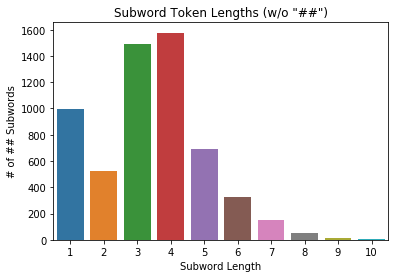

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.countplot(subword_lengths)
plt.title('Subword Token Lengths (w/o "##")')
plt.xlabel('Subword Length')
plt.ylabel('# of ## Subwords')

In [13]:
'misspelled' in tokenizer.vocab # Right

False

In [14]:
'mispelled' in tokenizer.vocab # Wrong

False

In [15]:
'beginning' in tokenizer.vocab # Right

True

In [16]:
'begining' in tokenizer.vocab # Wrong

False

In [17]:
"can't" in tokenizer.vocab

False

In [19]:
"cant" in tokenizer.vocab

True

## BERT for Question Answering
--------------------------

Let's apply BERT to the Stanford Question Answering Dataset (SQuAD) similar to how it was done in the original paper.

Given a question, and *a passage of text containing the answer*, BERT needs to highlight the "span" of text corresponding to the correct answer. 

The SQuAD homepage has a fantastic tool for exploring the questions and reference text for this dataset, and even shows the predictions made by top-performing models.

For example, here are some [interesting examples](https://rajpurkar.github.io/SQuAD-explorer/explore/v2.0/dev/Normans.html?model=BERT%20(single%20model)%20(Google%20AI%20Language)&version=v2.0) on the topic of Normans.


In [20]:
# let's install huggingface library that allows us to use pre-trained transformers

!pip install transformers

For Question Answering we use the `BertForQuestionAnswering` class from the `transformers` library.

This class supports fine-tuning, but for this example we will keep things simpler and load a BERT model that has already been fine-tuned for the SQuAD benchmark.

The `transformers` library has a large collection of pre-trained models which you can reference by name and load easily. The full list is in their documentation [here](https://huggingface.co/transformers/pretrained_models.html).

For Question Answering, they have a version of BERT-large that has already been fine-tuned for the SQuAD benchmark. 

BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your laptop.


In [21]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Load the tokenizer as well. 

Side note: Apparently the vocabulary of this model is identicaly to the one in bert-base-uncased. You can load the tokenizer from `bert-base-uncased` and that works just as well.

In [22]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Now we're ready to feed in an example!

A QA example consists of a question and a passage of text containing the answer to that question.

Let's try an example using the text in this tutorial!

In [49]:
#question = 'What are issues that we address in Computational Semantics course?'

#question = 'What time is it now?'

question = 'What is the goal of the course?'

answer_text = '''In this course we will discuss ways of representing meaning of words,
sentences and conversations with computational algorithms, address the issue of linguistic ambiguity, underspecification,
and similarity, examine how we can draw inferences or reason with these representations, and investigate how such representations
can be used in different language technology tasks.
The goal of the course is to learn about different representations of meaning that are used in natural language processing,
both top-down rule-based representations and data-driven representations obtained by machine learning,
contrast them with each other and examine their use in natural language tasks and applications.'''

In [57]:
question = 'What time is it now?'


answer_text = '''In this course we will discuss ways of representing meaning of words,
sentences and conversations with computational algorithms, address the issue of linguistic ambiguity, underspecification,
and similarity, examine how we can draw inferences or reason with these representations, and investigate how such representations
can be used in different language technology tasks. The time now is 3 PM.'''

We'll need to run the BERT tokenizer against both the `question` and the `answer_text`. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.


In [58]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 78 tokens.


In [59]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
what          2,054
time          2,051
is            2,003
it            2,009
now           2,085
?             1,029

[SEP]           102

in            1,999
this          2,023
course        2,607
we            2,057
will          2,097
discuss       6,848
ways          3,971
of            1,997
representing  5,052
meaning       3,574
of            1,997
words         2,616
,             1,010
sentences    11,746
and           1,998
conversations 11,450
with          2,007
computational 15,078
algorithms   13,792
,             1,010
address       4,769
the           1,996
issue         3,277
of            1,997
linguistic   12,158
ambiguity    27,637
,             1,010
under         2,104
##sp         13,102
##ec          8,586
##ification   9,031
,             1,010
and           1,998
similarity   14,402
,             1,010
examine      11,628
how           2,129
we            2,057
can           2,064
draw          4,009
inference    28,937
##s           2,

We've concatenated the `question` and `answer_text` together, but BERT still needs a way to distinguish them. BERT has two special "Segment" embeddings, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the `question` tokens, and the segment B embedding needs to be added to each of the `answer_text` tokens. 

These additions are handled for us by the `transformer` library, and all we need to do is specify a '0' or '1' for each token. 

Note: In the `transformers` library, huggingface likes to call these `token_type_ids`, but I'm going with `segment_ids` since this seems clearer, and is consistent with the BERT paper.

In [60]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

We're ready to feed our example into the model!


In [61]:
# Run our example through the model.
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True) 

start_scores = outputs.start_logits
end_scores = outputs.end_logits


Now we can highlight the answer just by looking at the most probable start and end words. 

In [62]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "3 pm"


With just a bit more work, we can reconstruct the correct answer without any subwords:

In [63]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "3 pm"


We can also inspect what were the scores for all words in our text:

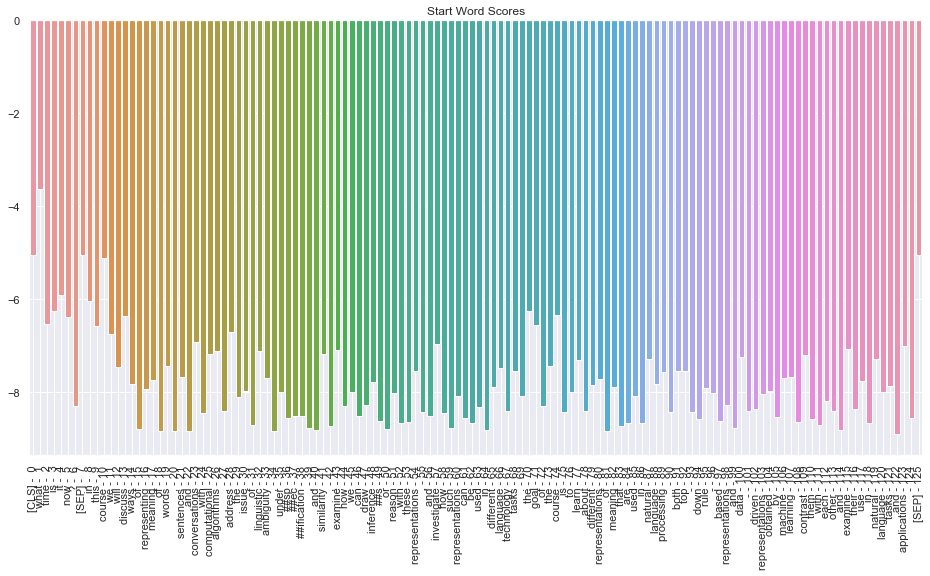

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

    
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

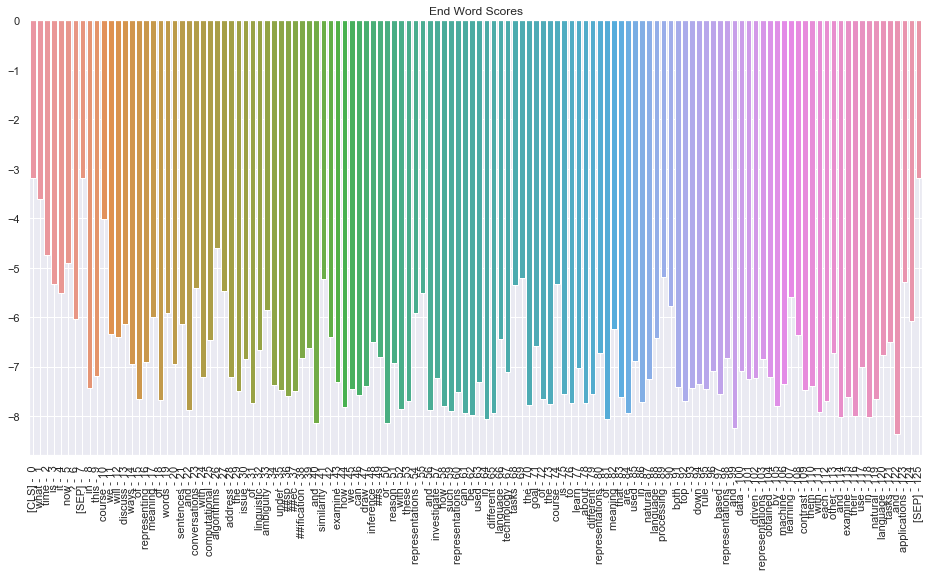

In [48]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()